In [22]:
Packages <- c("dplyr",  "nleqslv", "broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "stringr",  "lubridate", "RColorBrewer", "viridis")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_grid_search.R")
source("~/oceanography/scripts/neg_LL_biophys.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R")
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained

#source("~/oceanography/scripts/PredictedProportions.R")

#read in the kernel fitting summary
kernels <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv")
kernel2012_14 <- fread(file="~/oceanography/empirical_data/genetics/GenKernelsForROMSComp2012-14.csv")

#read in the centroids adjusted for the simulation, so the Magbangons combined 
#centroids <- fread(file="~/oceanography/script_output/SurveyData/SimulationCentroids.csv")
Centroids <- fread(file="~/oceanography/empirical_data/site_centroids_SimTest.csv") %>%
    arrange(site)
#setorder(Centroids, site)#warning! This sets order based on site, and then lat/lon. So the table is not alphabetical by site, but that's fine as long as all of the "sampled_reef" vectors reflect this, so that reef_sizes, distance, and sampled_reefs match up by row/col index 
#read in the table with number of recruits sampled at each site for each year
AnnualRecsSamp <- fread(file="~/oceanography/script_output/SurveyData/AnnualRecruitsSampled.csv")
#read in the table of the proportion of anemones sampled at each site for each year
PropSamp <- unique(fread(file="~/oceanography/script_output/SurveyData/ProportionHabitatSampled.csv")[
    , .(site, year=end_year, prop_anem_samp=total_prop_hab_sampled_anems_tidied)][ #select and rename columns with the tideied data to use
    site %like% "Magbangon", site := "Magbangon"][ #collapse Magbangon values
    , prop_anem_samp := sum(prop_anem_samp), by=c("site", "year")], by=c("site", "year"))[ #collapse magbangons to match ROMS data
    site=="Sitio Lonas" & year %in% c(2012, 2013, 2014), prop_anem_samp :=1][site=="Caridad Proper" & year %in% c(2013, 2014), prop_anem_samp :=1]
#add in the numbers of particles seeded at each site
SeededParticles <- fread("~/oceanography/ROMS/data/Particles_Per_Release_Site_Renamed.csv")
setnames(SeededParticles,c("source", "daily_particles_released")) 
#DateJoin <- SeededParticles[DateJoin, on="source"][, particles_released_daily := as.numeric(particles_released_daily)] 

#make vectors defining sites we didn't sample, but that are in the model, and the sandflats specifically 
unsampled_sites <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan", "Other", "CAI") 
sand_flats <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6") 
unrealistic_sources <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan") 
#make the constant inputs for the kernel fitting function
#distance matrix using the centroids with combined Magbangon
### List of source locations
SitesSource <- Centroids

### List of destination locations
SitesDest <- Centroids

DistMatm <- distm(SitesSource[,c('lon','lat')], SitesSource[,c('lon','lat')], fun=distVincentyEllipsoid)
Distances <- DistMatm*10^-3
#read in the reef areas for the kernel fitting
Area <- fread("~/oceanography/empirical_data/site_area_header_nonsurveyed_simulation_kernels_test.csv") %>%
    arrange(site) %>%
    filter(site %!in% c("near_north_full1", "near_north_full2", "near_north_full3", "near_south_full1", "near_south_full2", "near_south_full3")) %>%
    mutate(kmsq=msq*10^-6)# %>%
    #select(kmsq) #need to uncomment for functions to work
#setorder(Area, site)
reef_sizes <- as.matrix(Area$kmsq)

#make a site index table, use this for Sampled_reefs input in kernel fitting
SiteIndex <- unique(Centroids %>% arrange(site), by="site")[, index := .I] #add the row number as the unique site index, leave CAI in if fitting a kernel 
SiteIndexBioPhys <- unique(Centroids %>% arrange(site), by="site")[site != "CAI"][, index := .I] #add the row number as the unique site index, take CAI out for biophysical likelihood function

#make a table with the survey information for each site (how many fish sampled, prop anems sampled, total number of anems at site)
SurveyData <- AnnualRecsSamp[PropSamp, on=.(year, site)][#join the sampling tables together
    is.na(n_offs_gen), n_offs_gen := 0]#change NA's to 0
#setnames(SurveyData, c("PropAnemSamp", "TotalAnems"), c("prop_anem_samp", "total_anems"))
#setkey(SurveyData, site)
#check all sites are represented in centroids and area (and indirectly distances, which comes from centroids)
#Area[site %!in% centroids$site] #should be nothing

#Allison's abundance time series data 
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Script_outputs/females_df_F.RData?raw=true", destfile = "~/oceanography/empirical_data/genetics/females_df_F.RData")
load("~/oceanography/empirical_data/genetics/females_df_F.RData")
Abundance <- as.data.table(females_df_F)
setnames(Abundance, "nF", "num_females")
Abundance <- unique(Abundance[site %like% "Magbangon", site := "Magbangon"][ #collapse Magbangon values
            , num_females := sum(num_females), by=c("site", "year")], by=c("site", "year"))
#join the survey sampling tables together
SurveyData <- AnnualRecsSamp[PropSamp, on=.(year, site)][
    is.na(n_offs_gen), n_offs_gen := 0]#change NA's to 0


SurveyData <- Abundance[, c("year", "site", "num_females")][SurveyData, on=.(year, site)]#join in Allison's estimate of female abundance. There are NA values, but that's okay we can figure those out when we start thinking about incorporating uncertainty in this
#quick check that all components are in the same, alphabetical order
sum(which(SiteIndex$site==Area$site)==FALSE) #needs to be 0!! sites have to be in the same order
sum(which(Area$site==Centroids$site)==FALSE) #needs to be 0!! sites have to be in the same order



[1] 0

[1] 0

In [2]:
#read in the genetic parentage data and format for comparison
TotalPar2012_4 <- fread(file="~/oceanography/empirical_data/genetics/parentage_table_2012-14.csv")
TotalPar2012_4 <- unique(TotalPar2012_4[offs_site %like% "Magbangon", offs_site := "Magbangon"][par_site %like% "Magbangon", par_site := "Magbangon"][ #collapse Magbangon values
            , n_matches := sum(n_matches), by=c("offs_site", "par_site", "year")], by=c("offs_site", "par_site", "year"))

#add in all the sampled sites and numbers of recruits sampled at each site
TotalParInt <- unique(TotalPar2012_4[, num_matches := sum(n_matches), by=c("year", "offs_site")][, -"par_site"], by=c("year", "offs_site"))[, -"n_matches"]
#sum(TotalParInt$num_matches) #should be 37

TotalUnassigned2012_4 <- TotalParInt[SurveyData[year %in% c(2012, 2013, 2014)], on=.(offs_site=site, year)]
TotalUnassigned2012_4 [is.na(TotalUnassigned2012_4 )] <- 0

#sum(TotalUnassigned2012_4 $n_offs_gen) #should be 394
#sum(TotalUnassigned2012_4 $num_matches) #should be 37
#nrow(unique(TotalUnassigned2012_4 , by="offs_site"))#should be 18, so that every site is represented so that the years are all 18*18 sites
TotalUnassigned2012_4 <- TotalUnassigned2012_4[, num_unassigned := n_offs_gen-num_matches, by=c("year", "offs_site")][
    , .(offs_site, year, num_unassigned)]
#sum(TotalUnassigned2012_4$num_unassigned) #should be 357

#add in sites that aren't represented in as both parent and offspring possible site, based on assignments
AddDestGen <- rbindlist(list(unique(cbind(SurveyData[year %in% c(2012, 2013, 2014) ][, .(offs_site=site)], 
                  SurveyData[year %in% c(2012, 2013, 2014)][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2012],  #what destinations were sampled, for use with unassigned table
unique(cbind(SurveyData[year %in% c(2012, 2013, 2014) ][, .(offs_site=site)], 
                  SurveyData[year %in% c(2012, 2013, 2014)][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2013],
unique(cbind(SurveyData[year %in% c(2012, 2013, 2014) ][, .(offs_site=site)], 
                  SurveyData[year %in% c(2012, 2013, 2014)][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2014]))

TotalPar2012_4 <- rbind(AddDestGen[!TotalPar2012_4, on =.(par_site, offs_site, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , n_matches:=0 ], TotalPar2012_4[,-"num_matches"])  #add the parentage column, add back into the parentage table but drop the num_matches column that's a summary column I used to make the unassigned table 
#sum(TotalPar2012_4$n_matches)#should be 37 still

#format genetic parentage matrices for each year and all years combined
GenMat2012 <- as.matrix(rbind(dcast(TotalPar2012_4[year==2012, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[year==2012][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
GenMat2012[is.na(GenMat2012)] <- 0

GenMat2013 <- as.matrix(rbind(dcast(TotalPar2012_4[year==2013, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[year==2013][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
GenMat2013[is.na(GenMat2013)] <- 0

GenMat2014 <- as.matrix(rbind(dcast(TotalPar2012_4[year==2014, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[year==2014][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
GenMat2014[is.na(GenMat2014)] <- 0

GenMat2012_4 <- as.matrix(rbind(dcast(TotalPar2012_4[, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches", fun.aggregate = sum)[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[, .(num_unassigned=sum(num_unassigned)), by="offs_site"][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
GenMat2012_4[is.na(GenMat2012_4)] <- 0

#testing
#for monsoon seasons
MonsoonRecSampPar <- unique(fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitsByMonsoon2012-14ForROMSComp.csv")[
    , .(offs_site=site, par_site, monsoon=season)][offs_site %like% "Magbangon", offs_site := "Magbangon"][par_site %like% "Magbangon", par_site := "Magbangon"][ #collapse Magbangon values
    , num_gen := (.N), by=c("offs_site", "monsoon")][
    !is.na(par_site), n_matches := as.numeric((.N)), by=c("offs_site", "par_site", "monsoon")], by=c("offs_site", "par_site", "monsoon"))

#sum(unique(MonsoonRecSamp, by=c("offs_site","monsoon"))[, num_gen]) #should be 256MonsoonRecSamp <- unique(MonsoonRecSamp, by=c("site", "par_site", "monsoon", "year"))[
MonsoonRecSampPar <- unique(MonsoonRecSampPar, by=c("offs_site", "par_site", "monsoon"))[
    is.na(par_site), n_matches := 0, by=c("offs_site", "par_site", "monsoon")][
    , .(offs_site, par_site, monsoon, num_gen, n_matches)]
#sum(unique(MonsoonRecSampPar, by=c("offs_site","monsoon"))[, num_gen]) #should be 256
#sum(unique(MonsoonRecSampPar, by=c("offs_site", "par_site","monsoon"))[, n_matches]) #should be 17

#total recruits genotyped in each year and season at each site
MonsoonRecSamp <- unique(MonsoonRecSampPar, by=c("offs_site","monsoon"))[,-c("par_site", "n_matches")] #should be 256

#total parentage matches along each route in each year and season
ParMonsoon <- MonsoonRecSampPar[n_matches >0, -"num_gen"]
#print a summary table to check 
#ParMonsoon[, .(n_matches=sum(n_matches)) , by=c("monsoon")]
#sum(AnnualParMonsoon$n_matches) #should be 17

MonsoonParInt <- ParMonsoon[, .(num_matches = sum(n_matches)), by=c("monsoon", "offs_site")]#sum(MonsoonParInt$num_matches) #should be 17

#join all genotyped and assigned to get unassigned

MonsoonUnassigned <- MonsoonParInt[MonsoonRecSamp, on=.(offs_site, monsoon)]
MonsoonUnassigned[is.na(MonsoonUnassigned)] <- 0
MonsoonUnassigned[, num_unassigned := num_gen-num_matches]
#sum(MonsoonUnassigned$num_gen) #should be 256
#sum(MonsoonUnassigned$num_matches) #should be 17
MonsoonUnassigned <- MonsoonUnassigned[, .(offs_site,monsoon, num_unassigned)]

#AnnualParMonsoon #for assigned in matrix
#MonsoonUnassigned #for unassigned in matrix

#add in sites that aren't represented in every year
AddDestGen <- unique(cbind(SurveyData[year %in% c(2012, 2013, 2014) ][, .(offs_site=site)], 
                  SurveyData[year %in% c(2012, 2013, 2014)][ , .(par_site=site)]), by=c("offs_site", "par_site"))

AddDestGenMonsoon <- rbind(cbind(AddDestGen, data.table(monsoon = rep("NEM",nrow(AddDestGen)))), cbind(AddDestGen, data.table(monsoon = rep("SWM",nrow(AddDestGen)))))

ParMonsoon <- rbind(AddDestGenMonsoon[!ParMonsoon, on =.(par_site, offs_site, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , n_matches:=0 ], ParMonsoon)  #add the parentage column, add back into the parentage table but drop the num_matches column that's a summary column I used to make the unassigned table 
#ParMonsoon <- unique(ParMonsoon[, n_matches := sum(n_matches), by=c("par_site", "offs_site", "monsoon")], by=c("par_site", "offs_site", "monsoon"))
#sum(ParMonsoon$n_matches)#should be 17 still

MonsoonUnassigned <- rbind(AddDestGenMonsoon[!MonsoonUnassigned, on =.( offs_site, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , num_unassigned:=0 ][, -"par_site"], MonsoonUnassigned)  #add the parentage column, add back into the parentage table but drop the num_matches column that's a summary column I used to make the unassigned table 
#MonsoonUnassigned <- unique(MonsoonUnassigned[, num_unassigned := sum(num_unassigned), by=c("offs_site", "monsoon")], by=c("offs_site", "monsoon"))

#sum(MonsoonUnassigned$num_unassigned)#should be 256-17=239

#make into parentage matrices
GenMatNEM <- rbind(dcast(ParMonsoon[monsoon=="NEM"][, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(MonsoonUnassigned[monsoon=="NEM"][order(offs_site)][, .(num_unassigned)])), use.names=FALSE)
GenMatNEM[is.na(GenMatNEM)] <- 0
#dim(KernelGenMatNEM)
#sum(KernelGenMatNEM)
GenMatSWM <- rbind(dcast(ParMonsoon[monsoon=="SWM"][, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(MonsoonUnassigned[monsoon=="SWM"][order(offs_site)][, .(num_unassigned)])), use.names=FALSE)
GenMatSWM[is.na(GenMatSWM)] <- 0

#fwrite(GenMat2012_4, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2012-14ForROMSComp.csv")
#fwrite(GenMat2012, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2012ForROMSComp.csv")
#fwrite(GenMat2013, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2013ForROMSComp.csv")
#fwrite(GenMat2014, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrix2014ForROMSComp.csv")
#fwrite(GenMatNEM, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrixNEM2012-14ForROMSComp.csv")
#fwrite(GenMatSWM, file="~/oceanography/script_output/SurveyData/20210701_ParentageMatrixSWM2012-14ForROMSComp.csv")


In [3]:
#read in the genetic parentage data and format for comparison
TotalPar2012_4 <- fread(file="~/oceanography/empirical_data/genetics/parentage_table_2012-14.csv")
TotalPar2012_4 <- unique(TotalPar2012_4[offs_site %like% "Magbangon", offs_site := "Magbangon"][par_site %like% "Magbangon", par_site := "Magbangon"][ #collapse Magbangon values
            , n_matches := sum(n_matches), by=c("offs_site", "par_site", "year")], by=c("offs_site", "par_site", "year"))

#add in all the sampled sites and numbers of recruits sampled at each site
TotalParInt <- unique(TotalPar2012_4[, num_matches := sum(n_matches), by=c("year", "offs_site")][, -"par_site"], by=c("year", "offs_site"))[, -"n_matches"]
#sum(TotalParInt$num_matches) #should be 37

TotalUnassigned2012_4 <- TotalParInt[SurveyData[year %in% c(2012, 2013, 2014) & prop_anem_samp > 0 ], on=.(offs_site=site, year)]
TotalUnassigned2012_4 [is.na(TotalUnassigned2012_4 )] <- 0

#sum(TotalUnassigned2012_4 $n_offs_gen) #should be 394
#sum(TotalUnassigned2012_4 $num_matches) #should be 37
#nrow(unique(TotalUnassigned2012_4 , by="offs_site"))#should be 18, so that every site is represented so that the years are all 18*18 sites
TotalUnassigned2012_4 <- TotalUnassigned2012_4[, num_unassigned := n_offs_gen-num_matches, by=c("year", "offs_site")][
    , .(offs_site, year, num_unassigned)]
#sum(TotalUnassigned2012_4$num_unassigned) #should be 357

#add in sites that aren't represented in every year
AddDestGen <- rbindlist(list(unique(cbind(SurveyData[year==2012 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2012 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2012],  #what destinations were sampled, for use with unassigned table
unique(cbind(SurveyData[year==2013 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2013 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2013],
unique(cbind(SurveyData[year==2014 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2014 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2014]))

TotalPar2012_4 <- rbind(AddDestGen[!TotalPar2012_4, on =.(par_site, offs_site, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , n_matches:=0 ], TotalPar2012_4[,-"num_matches"])  #add the parentage column, add back into the parentage table but drop the num_matches column that's a summary column I used to make the unassigned table 
#sum(TotalPar2012_4$n_matches)#should be 37 still

#format genetic parentage matrices for each year and all years combined
KernelGenMat2012 <- as.matrix(rbind(dcast(TotalPar2012_4[year==2012, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[year==2012][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
KernelGenMat2012[is.na(KernelGenMat2012)] <- 0

KernelGenMat2013 <- as.matrix(rbind(dcast(TotalPar2012_4[year==2013, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[year==2013][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
KernelGenMat2013[is.na(KernelGenMat2013)] <- 0
#for monsoon seasons
MonsoonRecSampPar <- unique(fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitsByMonsoon2012-14ForROMSComp.csv")[
    , .(offs_site=site, par_site, monsoon=season)][offs_site %like% "Magbangon", offs_site := "Magbangon"][par_site %like% "Magbangon", par_site := "Magbangon"][ #collapse Magbangon values
    , num_gen := (.N), by=c("offs_site", "monsoon")][
    !is.na(par_site), n_matches := as.numeric((.N)), by=c("offs_site", "par_site", "monsoon")], by=c("offs_site", "par_site", "monsoon"))

#sum(unique(MonsoonRecSamp, by=c("offs_site","monsoon"))[, num_gen]) #should be 256MonsoonRecSamp <- unique(MonsoonRecSamp, by=c("site", "par_site", "monsoon", "year"))[
MonsoonRecSampPar <- unique(MonsoonRecSampPar, by=c("offs_site", "par_site", "monsoon"))[
    is.na(par_site), n_matches := 0, by=c("offs_site", "par_site", "monsoon")][
    , .(offs_site, par_site, monsoon, num_gen, n_matches)]
#sum(unique(MonsoonRecSampPar, by=c("offs_site","monsoon"))[, num_gen]) #should be 256
#sum(unique(MonsoonRecSampPar, by=c("offs_site", "par_site","monsoon"))[, n_matches]) #should be 17

#total recruits genotyped in each year and season at each site
MonsoonRecSamp <- unique(MonsoonRecSampPar, by=c("offs_site","monsoon"))[,-c("par_site", "n_matches")] #should be 256

#total parentage matches along each route in each year and season
ParMonsoon <- MonsoonRecSampPar[n_matches >0, -"num_gen"]
#print a summary table to check 
#ParMonsoon[, .(n_matches=sum(n_matches)) , by=c("monsoon")]
#sum(AnnualParMonsoon$n_matches) #should be 17

MonsoonParInt <- ParMonsoon[, .(num_matches = sum(n_matches)), by=c("monsoon", "offs_site")]#sum(MonsoonParInt$num_matches) #should be 17

#join all genotyped and assigned to get unassigned

MonsoonUnassigned <- MonsoonParInt[MonsoonRecSamp, on=.(offs_site, monsoon)]
MonsoonUnassigned[is.na(MonsoonUnassigned)] <- 0
MonsoonUnassigned[, num_unassigned := num_gen-num_matches]
#sum(MonsoonUnassigned$num_gen) #should be 256
#sum(MonsoonUnassigned$num_matches) #should be 17
MonsoonUnassigned <- MonsoonUnassigned[, .(offs_site,monsoon, num_unassigned)]

#AnnualParMonsoon #for assigned in matrix
#MonsoonUnassigned #for unassigned in matrix

#add in sites that aren't represented in every year
AddDestGen <- cbind(PropSamp[prop_anem_samp > 0 & year==2014, .(site)][, .(offs_site=site)], PropSamp[prop_anem_samp > 0 & year==2014, .(site)][, .(par_site=site)])

AddDestGenMonsoon <- rbind(cbind(AddDestGen, data.table(monsoon = rep("NEM",nrow(AddDestGen)))), cbind(AddDestGen, data.table(monsoon = rep("SWM",nrow(AddDestGen)))))

ParMonsoon <- rbind(AddDestGenMonsoon[!ParMonsoon, on =.(par_site, offs_site, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , n_matches:=0 ], ParMonsoon)  #add the parentage column, add back into the parentage table but drop the num_matches column that's a summary column I used to make the unassigned table 
#ParMonsoon <- unique(ParMonsoon[, n_matches := sum(n_matches), by=c("par_site", "offs_site", "monsoon")], by=c("par_site", "offs_site", "monsoon"))
#sum(ParMonsoon$n_matches)#should be 17 still

MonsoonUnassigned <- rbind(AddDestGenMonsoon[!MonsoonUnassigned, on =.( offs_site, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , num_unassigned:=0 ][, -"par_site"], MonsoonUnassigned)  #add the parentage column, add back into the parentage table but drop the num_matches column that's a summary column I used to make the unassigned table 
#MonsoonUnassigned <- unique(MonsoonUnassigned[, num_unassigned := sum(num_unassigned), by=c("offs_site", "monsoon")], by=c("offs_site", "monsoon"))

#sum(MonsoonUnassigned$num_unassigned)#should be 256-17=239

#make into parentage matrices
KernelGenMatNEM <- rbind(dcast(ParMonsoon[monsoon=="NEM"][, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(MonsoonUnassigned[monsoon=="NEM"][order(offs_site)][, .(num_unassigned)])), use.names=FALSE)
KernelGenMatNEM[is.na(KernelGenMatNEM)] <- 0
#dim(KernelGenMatNEM)
#sum(KernelGenMatNEM)

KernelGenMatSWM <- rbind(dcast(ParMonsoon[monsoon=="SWM"][, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(MonsoonUnassigned[monsoon=="SWM"][order(offs_site)][, .(num_unassigned)])), use.names=FALSE)
KernelGenMatSWM[is.na(KernelGenMatSWM)] <- 0
KernelGenMat2014 <- as.matrix(rbind(dcast(TotalPar2012_4[year==2014, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches")[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[year==2014][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
KernelGenMat2014[is.na(KernelGenMat2014)] <- 0

KernelGenMat2012_4 <- as.matrix(rbind(dcast(TotalPar2012_4[, .(par_site, offs_site, n_matches)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(par_site, offs_site)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , par_site ~ offs_site, value.var="n_matches", fun.aggregate = sum)[
    ,-"par_site"], #remove the source column after casting
      t(as.matrix(TotalUnassigned2012_4[, .(num_unassigned=sum(num_unassigned)), by="offs_site"][order(offs_site)][, .(num_unassigned)])), use.names=FALSE))
KernelGenMat2012_4[is.na(KernelGenMat2012_4)] <- 0


#fwrite(KernelGenMat2012_4, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2012-14ForROMSComp.csv")
#fwrite(KernelGenMat2012, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2012ForROMSComp.csv")
#fwrite(KernelGenMat2013, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2013ForROMSComp.csv")
#fwrite(KernelGenMat2014, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrix2014ForROMSComp.csv")
#fwrite(KernelGenMatNEM, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrixNEM2012-14ForROMSComp.csv")
#fwrite(KernelGenMatSWM, file="~/oceanography/script_output/SurveyData/20210701_KernelParentageMatrixSWM2012-14ForROMSComp.csv")


In [4]:
#format biophysical simulation matrices

In [4]:
#make a table of the dates of release for simulations, for calculating the number of particles released in each time frame
season1 <- data.table(date=seq(as.Date("2010-10-01"), as.Date("2011-05-31"), by="days"))

season2 <- data.table(date=seq(as.Date("2011-10-01"), as.Date("2012-05-31"), by="days"))

season3 <- data.table(date=seq(as.Date("2012-10-01"), as.Date("2013-05-31"), by="days"))

season4 <- data.table(date=seq(as.Date("2013-10-01"), as.Date("2014-04-18"), by="days"))

AllDates <- rbind(season1, season2, season3, season4)

#mark the monsoon seasons, based on the same criteria I used for the parentage indirectly through the growth estimates
NEM <- c(11, 12, 1, 2, 3, 4, 5, 6)
SWM <- c(7, 8, 9, 10)

AllDates[,date := ymd(date)][, #format as ymd
             sim_monsoon := ifelse(month(date) %in% NEM, "NEM", "SWM")][,#mark monsoon season based on month
             sim_year:=year(date)][,#add year column
            year_sampled:= ifelse(date %in% season1$date, 2011, ifelse(date %in% season2$date, 2012, ifelse(date %in% season3$date, 2013, 2014)))]#and then add a year_sampled for the empircal sampling season of that particle

ReleaseDays <- AllDates[, .(num_release_days_seasonal=.N), by=c("year_sampled", "sim_monsoon")][, num_release_days_annual:= sum(num_release_days_seasonal), by=year_sampled]

total_release_days <- AllDates[year_sampled %in% c(2012, 2013, 2014), .N]#for the all year kernel- how many days of the simulation conincide with our particle sampling?
total_release_days #should be 687


[1] 687

In [28]:
##prep biophysical connectivity matrix
SimConn <- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMetaLongForm08DayPLD.csv")[dest != "CAI"] #filter out CAI as a destination for now, not very well spatially defined
#outside of the loop, trim this to only be the destinations we sampled
SourceJoin <- SurveyData[SimConn, on = .(site = source, year=year_sampled)]
setnames(SourceJoin, skip_absent=TRUE, c("site", "n_offs_gen", "prop_anem_samp", "total_anems", "num_females"), c("source", "source_num_rec_sampled_annual",  "source_prop_anem_samp", "source_total_anems", "source_num_females"))
DestJoin <- SurveyData[SourceJoin, on = .(site = dest, year)]
setnames(DestJoin, skip_absent=TRUE, c("site", "n_offs_gen", "prop_anem_samp", "total_anems", "num_females"), c("dest", "dest_num_rec_sampled_annual",  "dest_prop_samp", "dest_total_anems", "dest_num_females"))

SimConn <- DestJoin[source %!in% unrealistic_sources & dest %!in% unrealistic_sources ][#& year %in% c(2012, 2013, 2014)#sand flats and Pangasugan are not realistic source or destination sites because there's almost no habitat. Safe to drop, but keep the rest of the possibilities so we can subsample iteratively all possibilities.
    , daily_particles_released := as.numeric(daily_particles_released)] #change from integer to numeric
SimConn <- ReleaseDays[SimConn, on=.(year_sampled=year, sim_monsoon)]#join in the info for number of release days in the time frame
SimConn <- kernels[Year %in% c("2012", "2013", "2014")][, year:=as.integer(Year)][,c("year", "NumParentageMatches")][SimConn, on=.(year=year_sampled)]#add in a column for the observed number of parentage matches
#rename the monsoon column in the full table for consistency
setnames(SimConn, c("sim_monsoon", "NumParentageMatches"), c("monsoon", "num_route_parentage_matches")) #get rid of upper case and inconsistent naming
setcolorder(SimConn, c("particle_id", "source", "dest", "year", "monsoon", "date"))

#at this point, we can make the raw number assignment matrix, but we want to make a normalized version that is num assigned from a source to a destination/ num released from that source
#fwrite(SimConn, file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableCompleteMetaLongForm08DayPLD.csv")

__Skip the joining of tables that takes forever and read in the__ 

In [8]:
SimConn <- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableCompleteMetaLongForm08DayPLD.csv")[dest != "CAI"] #filter out CAI as a destination for now, not very well spatially defined


In [30]:
head(SimConn)

particle_id,source,dest,year,monsoon,date,num_route_parentage_matches,num_release_days_seasonal,num_release_days_annual,dest_num_females,...,source_num_rec_sampled_annual,source_prop_anem_samp,sim_month,sim_day,sim_year,daily_particles_rec,daily_particles_released,dist_km,bearing,direction
P1,Other,Palanas,2011,SWM,2010-10-01,NA,31,243,NA,...,NA,NA,10,10,2010,9,4497728,NA,NA,NA
P2,Other,Palanas,2011,SWM,2010-10-01,NA,31,243,NA,...,NA,NA,10,10,2010,9,4497728,NA,NA,NA
P3,Other,Palanas,2011,SWM,2010-10-01,NA,31,243,NA,...,NA,NA,10,10,2010,9,4497728,NA,NA,NA
P4,Other,Palanas,2011,SWM,2010-10-01,NA,31,243,NA,...,NA,NA,10,10,2010,9,4497728,NA,NA,NA
P5,Other,Palanas,2011,SWM,2010-10-01,NA,31,243,NA,...,NA,NA,10,10,2010,9,4497728,NA,NA,NA
P6,Other,Palanas,2011,SWM,2010-10-01,NA,31,243,NA,...,NA,NA,10,10,2010,9,4497728,NA,NA,NA


In [10]:
##each year will require a different set of survey data, so make a list of each and index by site for fast look up
#SampledTable <- SurveyData[prop_anem_samp >0, c("year", "site")]#previously named PropSampTable
#
##make sure all sampled sites are represented when joining the survey data to the sampled simulation- this chunk has the tables to add to a subsampled particle table. no need for the full
#SampTable <- rbind(SurveyData[prop_anem_samp >0 & year %in% c(2012, 2013, 2014), c("year", "site")][, .(source=site, dest=site, year=year)][, #will join to the simulated sampling table by source and dest, so make those each a column from site and preserve the year variable as a key
#     c("year", "source", "dest")][, monsoon := "NEM"], SurveyData[prop_anem_samp >0 & year %in% c(2012, 2013, 2014), c("year", "site")][, .(source=site, dest=site, year=year)][, #will join to the simulated sampling table by source and dest, so make those each a column from site and preserve the year variable as a key
#     c("year", "source", "dest")][, monsoon := "SWM"])
#
#UnqSurvey <- unique(SampTable, by=c("source", "dest", "year", "monsoon"))#add in the diff Monsoon seasons so there are complete parentage matrices later
#
#make sure all possible routes are represented
AddDestSim <- rbind(rbindlist(list(unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2012],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2013], 
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2014]))[, monsoon := "NEM"],
    rbindlist(list(unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2012],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2013], 
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2014]))[, monsoon := "SWM"])

AddDestAllYearsSim <- unique(AddDestSim, by=c("source","dest"))[, -c("year","monsoon")] 

AddDestAnnualSim <- unique(AddDestSim, by=c("source","dest", "year"))[, -"monsoon"] 

AddDestMonsoonSim <- unique(AddDestSim[, -"year"], by=c("source", "dest", "monsoon"))
AddDestAnnualMonsoonSim <- unique(rbind(rbindlist(list(unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2011],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2012],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2013], 
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2014]))[, monsoon := "NEM"],
    rbindlist(list(unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2011],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2012],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2013], 
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2014]))[, monsoon := "SWM"])
    , by=c("source", "dest","year", "monsoon"))


##add in sites that aren't represented in every year by the genetics for the biophysical PARENTAGE matrix used to fit the biophysical kernel
AddDestGenAnnual <- rbindlist(list(unique(cbind(SurveyData[year==2012 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2012 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2012],  #what destinations were sampled, for use with unassigned table
unique(cbind(SurveyData[year==2013 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2013 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2013],
unique(cbind(SurveyData[year==2014 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2014 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2014]))

AddDestGen <- cbind(PropSamp[prop_anem_samp > 0 & year==2014, .(site)][, .(offs_site=site)], PropSamp[prop_anem_samp > 0 & year==2014, .(site)][, .(par_site=site)])

AddDestGenMonsoon <- rbind(cbind(AddDestGen, data.table(monsoon = rep("NEM",nrow(AddDestGen)))), cbind(AddDestGen, data.table(monsoon = rep("SWM",nrow(AddDestGen)))))


In [11]:
#make a normalized version that is num assigned from a source to a destination/ num released from that source
total_release_days <- 687

AllYearsRec <- SimConn[ , .(total_particles_rec = .N), by= c("source","dest")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
AllYearsRelease <- unique(SimConn[, .(total_particles_released = as.numeric(daily_particles_released)*as.numeric(total_release_days)), by= c("source")], by="source") #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

AllYearsRecInt <- rbind(AddDestAllYearsSim[!AllYearsRec, on =.(source, dest)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , total_particles_rec:=0 ], AllYearsRec) 

AllYearsReleaseInt <- rbind(AddDestAllYearsSim[!AllYearsRelease, on =.(source)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , total_particles_released:=0 ][, -"dest"], AllYearsRelease) 

#collapse CAI and "Other" together into "unknown" before making the normalized matrices
AllYearsRec <- unique(AllYearsRecInt[source== "Other" | source == "CAI", source := "unknown"][
    , total_particles_rec := sum(total_particles_rec),  by=c("source", "dest")], by=c("source", "dest"))
AllYearsRelease <- unique(AllYearsReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
    , total_particles_released := sum(total_particles_released), by="source"], by="source")

#join recruited and released tables together and make a column for the normalized values
AllYearsNormConn <-  AllYearsRelease[AllYearsRec, on="source"][
    , source_norm_rec := total_particles_rec/total_particles_released]

#check that they sum to =< 1
#AllYearsNormConn[,sum(source_norm_rec), by="source"]#nothing should be greater than 1. It isn't- great

#make sure all possible routes are represented!!*
#cast into wide format
FullBiophysMatNorm <- as.matrix(rbind(dcast(AllYearsNormConn[source !="unknown", .(source, dest, source_norm_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="source_norm_rec")[
    ,-"source"], #remove the source column after casting
      dcast(AllYearsNormConn[source == "unknown", .(source, dest, source_norm_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="source_norm_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
#dim(FullBiophysMatNorm )
FullBiophysMatNorm[is.na(FullBiophysMatNorm)] <- 0 #change NAs to zeros

#make annual matrices with all of the particle data
AnnualRec <- SimConn[ , .(annual_particles_rec = .N), by= c("source","dest", "year")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
AnnualRelease <- unique(SimConn[, .(annual_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_annual)), by= c("source", "year")], by= c("source", "year")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

AnnualRecInt <- rbind(AddDestAnnualSim[!AnnualRec, on =.(source, dest, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , annual_particles_rec:=0 ], AnnualRec) 

AnnualReleaseInt <- rbind(AddDestAnnualSim[!AnnualRelease, on =.(source, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , annual_particles_released:=0 ][, -"dest"], AnnualRelease) 

#collapse CAI and "Other" together into "unknown" before making the normalized matrices
AnnualRec <- unique(AnnualRecInt[source== "Other" | source == "CAI", source := "unknown"][
    , annual_particles_rec := sum(annual_particles_rec), by=c("source", "dest", "year")], by=c("source", "dest", "year"))
AnnualRelease <- unique(AnnualReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
    , annual_particles_released := sum(annual_particles_released), by=c("source", "year")], by=c("source", "year"))

#join recruited and released tables together and make a column for the normalized values
AnnualNormConn <-  AnnualRelease[AnnualRec, on=c("source", "year")][
    , source_norm_rec := annual_particles_rec/annual_particles_released]
#check that they sum to =< 1
#summary(AnnualNormConn[, .(sum=sum(source_norm_rec)), by=c("year", "source")][, sum])#nothing should exceed 1, it doesn't- great

#cast into wide format for each year

AnnualBiophysMatNorm2012 <- as.matrix(rbind(dcast(AnnualNormConn[year==2012 & source != "unknown", .(source, dest, source_norm_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="source_norm_rec")[
    ,-"source"], #remove the source column after casting
      dcast(AnnualNormConn[year==2012][source == "unknown", .(source, dest, source_norm_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="source_norm_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
#dim(AnnualBiophysMatNorm2012)
AnnualBiophysMatNorm2012[is.na(AnnualBiophysMatNorm2012)] <- 0 #change NAs to zeros

AnnualBiophysMatNorm2013 <- as.matrix(rbind(dcast(AnnualNormConn[year==2013 & source != "unknown", .(source, dest, source_norm_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="source_norm_rec")[
    ,-"source"], #remove the source column after casting
      dcast(AnnualNormConn[year==2013][source == "unknown", .(source, dest, source_norm_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="source_norm_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
#dim(AnnualBiophysMatNorm2013)
AnnualBiophysMatNorm2013[is.na(AnnualBiophysMatNorm2013)] <- 0 #change NAs to zeros

AnnualBiophysMatNorm2014 <- as.matrix(rbind(dcast(AnnualNormConn[year==2014 & source != "unknown", .(source, dest, source_norm_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="source_norm_rec")[
    ,-"source"], #remove the source column after casting
      dcast(AnnualNormConn[year==2014][source == "unknown", .(source, dest, source_norm_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="source_norm_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
#dim(AnnualBiophysMatNorm2014)
AnnualBiophysMatNorm2014[is.na(AnnualBiophysMatNorm2014)] <- 0 #change NAs to zeros

#make monsoon matrices with all of the particle data
MonsoonRec <- SimConn[ , .(monsoon_particles_rec = .N), by= c("source","dest", "monsoon")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
MonsoonRelease <- unique(SimConn[, .(monsoon_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_seasonal)), by= c("source", "monsoon")], by= c("source", "monsoon")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

MonsoonRec <- SimConn[ , .(monsoon_particles_rec = .N), by= c("source","dest", "monsoon")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
MonsoonRelease <- unique(SimConn[, .(monsoon_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_seasonal)), by= c("source", "monsoon")], by= c("source", "monsoon")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

MonsoonRecInt <- rbind(AddDestMonsoonSim[!MonsoonRec, on =.(source, dest, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , monsoon_particles_rec:=0 ], MonsoonRec) 

MonsoonReleaseInt <- rbind(AddDestMonsoonSim[!MonsoonRelease, on =.(source, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , monsoon_particles_released:=0 ][, -"dest"], MonsoonRelease) 

#collapse CAI and "Other" together into "unknown" before making the normalized matrices
MonsoonRec <- unique(MonsoonRecInt[source== "Other" | source == "CAI", source := "unknown"][
    , monsoon_particles_rec := sum(monsoon_particles_rec), by=c("source", "dest", "monsoon")], by=c("source", "dest", "monsoon"))
MonsoonRelease <- unique(MonsoonReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
    , monsoon_particles_released := sum(monsoon_particles_released), by=c("source", "monsoon")], by=c("source", "monsoon"))

#join recruited and released tables together and make a column for the normalized values
MonsoonNormConn <-  MonsoonRelease[MonsoonRec, on=c("source", "monsoon")][
    , source_norm_rec := monsoon_particles_rec/monsoon_particles_released]
#check that they sum to =< 1
#summary(MonsoonNormConn[, .(sum=sum(source_norm_rec)), by=c("monsoon", "source")][, sum])#nothing should exceed 1, it doesn't- great

MonsoonBiophysMatNormNEM <- as.matrix(rbind(dcast(MonsoonNormConn[monsoon=="NEM" & source != "unknown", .(source, dest, source_norm_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="source_norm_rec")[
    ,-"source"], #remove the source column after casting
      dcast(MonsoonNormConn[monsoon=="NEM"][source == "unknown", .(source, dest, source_norm_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="source_norm_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
#dim(MonsoonBiophysMatNormNEM)
MonsoonBiophysMatNormNEM[is.na(MonsoonBiophysMatNormNEM)] <- 0 #change NAs to zeros

MonsoonBiophysMatNormSWM <- as.matrix(rbind(dcast(MonsoonNormConn[monsoon=="SWM" & source != "unknown", .(source, dest, source_norm_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="source_norm_rec")[
    ,-"source"], #remove the source column after casting
      dcast(MonsoonNormConn[monsoon=="SWM"][source == "unknown", .(source, dest, source_norm_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="source_norm_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
#dim(MonsoonBiophysMatNormSWM)
MonsoonBiophysMatNormSWM[is.na(MonsoonBiophysMatNormSWM)] <- 0 #change NAs to zeros

#fwrite(FullBiophysMatNorm, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysNormConnMatrix2012-14ForROMSComp15DayPLD.csv")
#fwrite(AnnualBiophysMatNorm2012, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysNormConnMatrix2012ForROMSComp15DayPLD.csv")
#fwrite(AnnualBiophysMatNorm2013, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysNormConnMatrix2013ForROMSComp15DayPLD.csv")
#fwrite(AnnualBiophysMatNorm2014, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysNormConnMatrix2014ForROMSComp15DayPLD.csv")
#fwrite(MonsoonBiophysMatNormNEM, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysNormConnMatrixNEM2012-14ForROMSComp15DayPLD.csv")
#fwrite(MonsoonBiophysMatNormSWM, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysNormConnMatrixSWM2012-14ForROMSComp15DayPLD.csv")

In [12]:
#make a parentage matrix for the whole biophysical results- CAI included with Other as "unknown", use this to fit a kernel
FullBiophysMat <- as.matrix(rbind(dcast(AllYearsNormConn[source %in% AddDestGenAnnual[, par_site] & dest %in% AddDestGenAnnual[, offs_site]][source !="unknown", .(source, dest, total_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="total_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
      dcast(AllYearsNormConn[dest %in% AddDestGenAnnual[, offs_site]][source  == "unknown", .(source, dest, total_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="total_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
FullBiophysMat[is.na(FullBiophysMat)] <- 0 #change NAs to zerosdim(FullBiophysMat)
dim(FullBiophysMat)
#parentage matrix by years and monsoons
AnnualBiophysMat2012 <- as.matrix(rbind(dcast(AnnualNormConn[year==2012][source %in% AddDestGenAnnual[year==2012, par_site] & dest %in% AddDestGenAnnual[year==2012, offs_site]][source !="unknown", .(source, dest, annual_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="annual_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(AnnualNormConn[year==2012][dest %in% AddDestGenAnnual[year==2012, offs_site]][source  == "unknown", .(source, dest, annual_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="annual_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
AnnualBiophysMat2012[is.na(AnnualBiophysMat2012)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2012)

AnnualBiophysMat2013 <- as.matrix(rbind(dcast(AnnualNormConn[year==2013][source %in% AddDestGenAnnual[year==2013, par_site] & dest %in% AddDestGenAnnual[year==2013, offs_site]][source !="unknown", .(source, dest, annual_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="annual_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(AnnualNormConn[year==2013][dest %in% AddDestGenAnnual[year==2013, offs_site]][source  == "unknown", .(source, dest, annual_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="annual_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
AnnualBiophysMat2013[is.na(AnnualBiophysMat2013)] <- 0 #change NAs to zeros
dim(AnnualBiophysMat2013)

AnnualBiophysMat2014 <- as.matrix(rbind(dcast(AnnualNormConn[year==2014][source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]][source !="unknown", .(source, dest, annual_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="annual_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(AnnualNormConn[year==2014][dest %in% AddDestGenAnnual[year==2014, offs_site]][source  == "unknown", .(source, dest, annual_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="annual_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
AnnualBiophysMat2014[is.na(AnnualBiophysMat2014)] <- 0 #change NAs to zeros
dim(AnnualBiophysMat2014)

MonsoonBiophysMatNEM <- as.matrix(rbind(dcast(MonsoonNormConn[source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]][monsoon=="NEM" & source != "unknown", .(source, dest, monsoon_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[
    ,-"source"], #remove the source column after casting
      dcast(MonsoonNormConn[monsoon=="NEM"][dest %in% AddDestGenAnnual[year==2014, offs_site]][source == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
MonsoonBiophysMatNEM[is.na(MonsoonBiophysMatNEM)] <- 0 #change NAs to zeros
dim(MonsoonBiophysMatNEM)

MonsoonBiophysMatSWM <- as.matrix(rbind(dcast(MonsoonNormConn[source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]][monsoon=="SWM" & source != "unknown", .(source, dest, monsoon_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[
    ,-"source"], #remove the source column after casting
      dcast(MonsoonNormConn[monsoon=="SWM"][dest %in% AddDestGenAnnual[year==2014, offs_site]][source == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
MonsoonBiophysMatSWM[is.na(MonsoonBiophysMatSWM)] <- 0 #change NAs to zeros
dim(MonsoonBiophysMatSWM)
#fwrite(FullBiophysMat, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrix2012-14ForROMSComp15DayPLD.csv")
#fwrite(AnnualBiophysMat2012, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrix2012ForROMSComp15DayPLD.csv")
#fwrite(AnnualBiophysMat2013, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrix2013ForROMSComp15DayPLD.csv")
#fwrite(AnnualBiophysMat2014, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrix2014ForROMSComp15DayPLD.csv")
#fwrite(MonsoonBiophysMatNEM, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixNEM2012-14ForROMSComp15DayPLD.csv")
#fwrite(MonsoonBiophysMatSWM, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixSWM2012-14ForROMSComp15DayPLD.csv")

[1] 17 16

[1] 17 16

[1] 17 16

[1] 17 16

[1] 17 16

In [ ]:
#get the best-fit kernels in fit_data.ipynb

In [33]:
#bootstrap the particle data and re-fit kernels
num <- nrow(SimConn)

#make sure all possible routes are represented
AddDestSim <- rbind(rbindlist(list(unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2011],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2012],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2013], 
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2014]))[, monsoon := "NEM"],
    rbindlist(list(unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2011],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2012],
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2013], 
        unique(SimConn[, .(source, dest)], by=c("source", "dest"))[, year := 2014]))[, monsoon := "SWM"])

AddDestAllYearsSim <- unique(AddDestSim, by=c("source","dest"))[, -c("year","monsoon")] 

AddDestAnnualSim <- unique(AddDestSim, by=c("source","dest", "year"))[, -"monsoon"] 

AddDestMonsoonSim <- unique(AddDestSim[, -"year"], by=c("source", "dest", "monsoon"))
AddDestAnuualMonsoonSim <- unique(AddDestSim, by=c("source", "dest","year", "monsoon"))

##add in sites that aren't represented in every year by the genetics for the biophysical PARENTAGE matrix used to fit the biophysical kernel
AddDestGenAnnual <- rbindlist(list(unique(cbind(SurveyData[year==2012 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2012 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2012],  #what destinations were sampled, for use with unassigned table
unique(cbind(SurveyData[year==2013 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2013 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2013],
unique(cbind(SurveyData[year==2014 & prop_anem_samp >0 ][, .(offs_site=site)], 
                  SurveyData[year==2014 & prop_anem_samp >0 ][ , .(par_site=site)]), by=c("offs_site", "par_site"))[, year := 2014]))

AddDestGen <- cbind(PropSamp[prop_anem_samp > 0 & year==2014, .(site)][, .(offs_site=site)], PropSamp[prop_anem_samp > 0 & year==2014, .(site)][, .(par_site=site)])

AddDestGenMonsoon <- rbind(cbind(AddDestGen, data.table(monsoon = rep("NEM",nrow(AddDestGen)))), cbind(AddDestGen, data.table(monsoon = rep("SWM",nrow(AddDestGen)))))

#read in all data needed for kernel fitting
#read in the centroids adjusted for the simulation, so the Magbangons combined 
#centroids <- fread(file="~/oceanography/script_output/SurveyData/SimulationCentroids.csv")
Centroids <- fread(file="~/oceanography/empirical_data/site_centroids_SimTest.csv") 
Centroids$site <- gsub("_full", "", Centroids$site, fixed=TRUE)
Centroids$site <- gsub("_ten_per_cover", "", Centroids$site, fixed=TRUE)

Centroids <- Centroids %>%
    arrange(site)

#setorder(Centroids, site)#warning! This sets order based on site, and then lat/lon. So the table is not alphabetical by site, but that's fine as long as all of the "sampled_reef" vectors reflect this, so that reef_sizes, distance, and sampled_reefs match up by row/col index 
#read in the table with number of recruits sampled at each site for each year
AnnualRecsSamp <- fread(file="~/oceanography/script_output/SurveyData/AnnualRecruitsSampled.csv")
#read in the table of the proportion of anemones sampled at each site for each year
PropSamp <- unique(fread(file="~/oceanography/script_output/SurveyData/ProportionHabitatSampled.csv")[
    , .(site, year=end_year, prop_anem_samp=total_prop_hab_sampled_anems_tidied)][ #select and rename columns with the tideied data to use
    site %like% "Magbangon", site := "Magbangon"][ #collapse Magbangon values
    , prop_anem_samp := sum(prop_anem_samp), by=c("site", "year")], by=c("site", "year"))[ #collapse magbangons to match ROMS data
    site=="Sitio Lonas" & year %in% c(2012, 2013, 2014), prop_anem_samp :=1][site=="Caridad Proper" & year %in% c(2013, 2014), prop_anem_samp :=1]

### List of source locations
SitesSource <- Centroids

### List of destination locations
SitesDest <- Centroids

DistMatm <- distm(SitesSource[,c('lon','lat')], SitesSource[,c('lon','lat')], fun=distVincentyEllipsoid)
Distances <- DistMatm*10^-3
#read in the reef areas for the kernel fitting
Area <- fread("~/oceanography/empirical_data/site_area_header_nonsurveyed_simulation_kernels_test.csv") %>%
    arrange(site) %>%
    filter(site %!in% c("near_north_full1", "near_north_full2", "near_north_full3", "near_south_full1", "near_south_full2", "near_south_full3")) %>%
    mutate(kmsq=msq*10^-6)# %>%
    #select(kmsq) #need to uncomment for functions to work
Area$site <- gsub("_ten_per_cover", "", Area$site, fixed=TRUE)

reef_sizes <- as.matrix(Area$kmsq)

#make a site index table, use this for Sampled_reefs input in kernel fitting
SiteIndex <- unique(Centroids %>% arrange(site), by="site")[, index := .I] #add the row number as the unique site index, leave CAI in if fitting a kernel 
SiteIndexBioPhys <- unique(Centroids %>% arrange(site), by="site")[site != "CAI"][, index := .I] #add the row number as the unique site index, take CAI out for biophysical likelihood function

#make a table with the survey information for each site (how many fish sampled, prop anems sampled, total number of anems at site)
SurveyData <- AnnualRecsSamp[PropSamp, on=.(year, site)][#join the sampling tables together
    is.na(n_offs_gen), n_offs_gen := 0]#change NA's to 0
#setnames(SurveyData, c("PropAnemSamp", "TotalAnems"), c("prop_anem_samp", "total_anems"))
#setkey(SurveyData, site)
#check all sites are represented in centroids and area (and indirectly distances, which comes from centroids)
#Area[site %!in% centroids$site] #should be nothing

#Allison's abundance time series data 
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Script_outputs/females_df_F.RData?raw=true", destfile = "~/oceanography/empirical_data/genetics/females_df_F.RData")
load("~/oceanography/empirical_data/genetics/females_df_F.RData")
Abundance <- as.data.table(females_df_F)
setnames(Abundance, "nF", "num_females")
Abundance <- unique(Abundance[site %like% "Magbangon", site := "Magbangon"][ #collapse Magbangon values
            , num_females := sum(num_females), by=c("site", "year")], by=c("site", "year"))
#join the survey sampling tables together
SurveyData <- AnnualRecsSamp[PropSamp, on=.(year, site)][
    is.na(n_offs_gen), n_offs_gen := 0]#change NA's to 0


SurveyData <- Abundance[, c("year", "site", "num_females")][SurveyData, on=.(year, site)]#join in Allison's estimate of female abundance. There are NA values, but that's okay we can figure those out when we start thinking about incorporating uncertainty in this
#quick check that all components are in the same, alphabetical order
sum(which(SiteIndex$site==Area$site)==FALSE) #needs to be 0!! sites have to be in the same order
sum(which(Area$site==Centroids$site)==FALSE) #needs to be 0!! sites have to be in the same order

#start bootstrapping
SimKernels <- data.table(time_scale=character(), time_id=character(), k=numeric(), theta=numeric(), mdd=numeric(), med=numeric(), dist90=numeric(), log_like=numeric(), iteration=numeric())

pb <- txtProgressBar(min = 0, max = 1000, style = 3)

for(i in 1:1000){
    
    SimConnInt <- SimConn[, .SD[sample(.N, num, replace=TRUE)]] #sample the particle data
    
#format the matrices

    AllYearsRec <- SimConnInt[ , .(total_particles_rec = .N), by= c("source","dest")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
    AllYearsRelease <- unique(SimConnInt[, .(total_particles_released = as.numeric(daily_particles_released)*as.numeric(total_release_days)), by= c("source")], by="source") #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs
    
    AllYearsRecInt <- rbind(AddDestAllYearsSim[!AllYearsRec, on =.(source, dest)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
        , total_particles_rec:=0 ], AllYearsRec) 
    
    AllYearsReleaseInt <- rbind(AddDestAllYearsSim[!AllYearsRelease, on =.(source)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
        , total_particles_released:=0 ][, -"dest"], AllYearsRelease) 
    
    #collapse CAI and "Other" together into "unknown" before making the normalized matrices
    AllYearsRec <- unique(AllYearsRecInt[source== "Other" | source == "CAI", source := "unknown"][
        , total_particles_rec := sum(total_particles_rec),  by=c("source", "dest")], by=c("source", "dest"))
    AllYearsRelease <- unique(AllYearsReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
        , total_particles_released := sum(total_particles_released), by="source"], by="source")
    
    #join recruited and released tables together and make a column for the normalized values
    AllYearsNormConn <-  AllYearsRelease[AllYearsRec, on="source"][
        , source_norm_rec := total_particles_rec/total_particles_released]

    #make a parentage matrix for the whole biophysical results- CAI included with Other as "unknown", use this to fit a kernel
FullBiophysMat <- as.matrix(rbind(dcast(AllYearsNormConn[source %in% AddDestGenAnnual[, par_site] & dest %in% AddDestGenAnnual[, offs_site]][source !="unknown", .(source, dest, total_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="total_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
      dcast(AllYearsNormConn[dest %in% AddDestGenAnnual[, offs_site]][source  == "unknown", .(source, dest, total_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="total_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
FullBiophysMat[is.na(FullBiophysMat)] <- 0 #change NAs to zerosdim(FullBiophysMat)
#dim(FullBiophysMat)
#parentage matrix by years and monsoons
    
#make annual matrices with all of the particle data
AnnualRec <- SimConnInt[ , .(annual_particles_rec = .N), by= c("source","dest", "year")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
AnnualRelease <- unique(SimConnInt[, .(annual_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_annual)), by= c("source", "year")], by= c("source", "year")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

AnnualRecInt <- rbind(AddDestAnnualSim[!AnnualRec, on =.(source, dest, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , annual_particles_rec:=0 ], AnnualRec) 

AnnualReleaseInt <- rbind(AddDestAnnualSim[!AnnualRelease, on =.(source, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , annual_particles_released:=0 ][, -"dest"], AnnualRelease) 

#collapse CAI and "Other" together into "unknown" before making the normalized matrices
AnnualRec <- unique(AnnualRecInt[source== "Other" | source == "CAI", source := "unknown"][
    , annual_particles_rec := sum(annual_particles_rec), by=c("source", "dest", "year")], by=c("source", "dest", "year"))
AnnualRelease <- unique(AnnualReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
    , annual_particles_released := sum(annual_particles_released), by=c("source", "year")], by=c("source", "year"))

#join recruited and released tables together and make a column for the normalized values
AnnualNormConn <-  AnnualRelease[AnnualRec, on=c("source", "year")][
    , source_norm_rec := annual_particles_rec/annual_particles_released]

AnnualBiophysMat2012 <- as.matrix(rbind(dcast(AnnualNormConn[year==2012][source %in% AddDestGenAnnual[year==2012, par_site] & dest %in% AddDestGenAnnual[year==2012, offs_site]][source !="unknown", .(source, dest, annual_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="annual_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(AnnualNormConn[year==2012][dest %in% AddDestGenAnnual[year==2012, offs_site]][source  == "unknown", .(source, dest, annual_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="annual_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
AnnualBiophysMat2012[is.na(AnnualBiophysMat2012)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2012)

AnnualBiophysMat2013 <- as.matrix(rbind(dcast(AnnualNormConn[year==2013][source %in% AddDestGenAnnual[year==2013, par_site] & dest %in% AddDestGenAnnual[year==2013, offs_site]][source !="unknown", .(source, dest, annual_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="annual_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(AnnualNormConn[year==2013][dest %in% AddDestGenAnnual[year==2013, offs_site]][source  == "unknown", .(source, dest, annual_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="annual_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
AnnualBiophysMat2013[is.na(AnnualBiophysMat2013)] <- 0 #change NAs to zeros
#dim(AnnualBiophysMat2013)

AnnualBiophysMat2014 <- as.matrix(rbind(dcast(AnnualNormConn[year==2014][source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]][source !="unknown", .(source, dest, annual_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="annual_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(AnnualNormConn[year==2014][dest %in% AddDestGenAnnual[year==2014, offs_site]][source  == "unknown", .(source, dest, annual_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="annual_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
AnnualBiophysMat2014[is.na(AnnualBiophysMat2014)] <- 0 #change NAs to zeros
#dim(AnnualBiophysMat2014)

MonsoonRec <- SimConnInt[ , .(monsoon_particles_rec = .N), by= c("source","dest", "monsoon")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
MonsoonRelease <- unique(SimConnInt[, .(monsoon_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_seasonal)), by= c("source", "monsoon")], by= c("source", "monsoon")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

MonsoonRec <- SimConnInt[ , .(monsoon_particles_rec = .N), by= c("source","dest", "monsoon")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
MonsoonRelease <- unique(SimConnInt[, .(monsoon_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_seasonal)), by= c("source", "monsoon")], by= c("source", "monsoon")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

MonsoonRecInt <- rbind(AddDestMonsoonSim[!MonsoonRec, on =.(source, dest, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , monsoon_particles_rec:=0 ], MonsoonRec) 

MonsoonReleaseInt <- rbind(AddDestMonsoonSim[!MonsoonRelease, on =.(source, monsoon)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , monsoon_particles_released:=0 ][, -"dest"], MonsoonRelease) 

#collapse CAI and "Other" together into "unknown" before making the normalized matrices
MonsoonRec <- unique(MonsoonRecInt[source== "Other" | source == "CAI", source := "unknown"][
    , monsoon_particles_rec := sum(monsoon_particles_rec), by=c("source", "dest", "monsoon")], by=c("source", "dest", "monsoon"))
MonsoonRelease <- unique(MonsoonReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
    , monsoon_particles_released := sum(monsoon_particles_released), by=c("source", "monsoon")], by=c("source", "monsoon"))

#join recruited and released tables together and make a column for the normalized values
MonsoonNormConn <-  MonsoonRelease[MonsoonRec, on=c("source", "monsoon")][
    , source_norm_rec := monsoon_particles_rec/monsoon_particles_released]
  
    
MonsoonBiophysMatNEM <- as.matrix(rbind(dcast(MonsoonNormConn[source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]][monsoon=="NEM" & source != "unknown", .(source, dest, monsoon_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[
    ,-"source"], #remove the source column after casting
      dcast(MonsoonNormConn[monsoon=="NEM"][dest %in% AddDestGenAnnual[year==2014, offs_site]][source == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
MonsoonBiophysMatNEM[is.na(MonsoonBiophysMatNEM)] <- 0 #change NAs to zeros
#dim(MonsoonBiophysMatNEM)

MonsoonBiophysMatSWM <- as.matrix(rbind(dcast(MonsoonNormConn[source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]][monsoon=="SWM" & source != "unknown", .(source, dest, monsoon_particles_rec)][ #for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[
    ,-"source"], #remove the source column after casting
      dcast(MonsoonNormConn[monsoon=="SWM"][dest %in% AddDestGenAnnual[year==2014, offs_site]][source == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
          order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))#bind these two cast wide form data tables (assigned and unassigned particles) and then turn into a matrix to be used in the likelihood functions
MonsoonBiophysMatSWM[is.na(MonsoonBiophysMatSWM)] <- 0 #change NAs to zeros
#dim(MonsoonBiophysMatSWM)

#fit the kernels
    #fit the kernels, get the biophysical data together
biophys_par_data2012 <- list(Distances=Distances, Assignments=AnnualBiophysMat2012, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2012 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(AnnualBiophysMat2012), ncol=1, 1))
Sim2012Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2012, control=list(maxit=500)))

biophys_par_data2013 <- list(Distances=Distances, Assignments=AnnualBiophysMat2013, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2013 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(AnnualBiophysMat2013), ncol=1, 1))
Sim2013Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2013, control=list(maxit=500)))

biophys_par_data2014 <- list(Distances=Distances, Assignments=AnnualBiophysMat2014, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(AnnualBiophysMat2014), ncol=1, 1))
Sim2014Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2014, control=list(maxit=500)))

biophys_par_data2012_4 <- list(Distances=Distances, Assignments=FullBiophysMat, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(FullBiophysMat), ncol=1, 1))
Sim2012_4Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_data2012_4, control=list(maxit=500)))

biophys_par_dataNEM <- list(Distances=Distances, Assignments=MonsoonBiophysMatNEM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(MonsoonBiophysMatNEM), ncol=1, 1))
SimNEMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_dataNEM, control=list(maxit=500)))

biophys_par_dataSWM <- list(Distances=Distances, Assignments=MonsoonBiophysMatSWM, Sampled_reefs=t(as.matrix(SiteIndex[site %in% SurveyData[year==2014 & prop_anem_samp >0 , site], .(index)])), 
                  Reef_sizes=reef_sizes, Adult_sample_proportions=matrix(nrow=ncol(MonsoonBiophysMatSWM), ncol=1, 1))
SimSWMFit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 5), method="L-BFGS-B", data=biophys_par_dataSWM, control=list(maxit=500)))

#make a summary table for all time frames of simulation data
SimKernelsInt <- as.data.frame(matrix(NA, nrow = 6, ncol = 8))
setDT(SimKernelsInt)
setnames(SimKernelsInt, c("time_scale", "time_id", "k", "theta", "mdd", "med", "dist90", "log_like"))


BestK2012 <- as.numeric(coef(Sim2012Fit)[1])
BestTheta2012 <- as.numeric(coef(Sim2012Fit)[2])
MDD2012 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012, theta=BestTheta2012, , method = "pcubature")$integral)
k_eval <- BestK2012
theta_eval <- BestTheta2012
Med2012  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) 
Dist90_2012 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)

SimKernelsInt$time_scale[1] <- "annual"
SimKernelsInt$time_id[1] <- "2012"
SimKernelsInt$k[1] <-  BestK2012
SimKernelsInt$theta[1] <- BestTheta2012
SimKernelsInt$mdd[1] <- MDD2012
SimKernelsInt$med[1] <- Med2012
SimKernelsInt$dist90[1] <- Dist90_2012
SimKernelsInt$log_like[1] <- logLik(Sim2012Fit)[1]

BestK2013 <- as.numeric(coef(Sim2013Fit)[1])
BestTheta2013 <- as.numeric(coef(Sim2013Fit)[2])
MDD2013 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2013, theta=BestTheta2013, , method = "pcubature")$integral)
k_eval <- BestK2013
theta_eval <- BestTheta2013
Med2013  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) 
Dist90_2013 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)

SimKernelsInt$time_scale[2] <- "annual"
SimKernelsInt$time_id[2] <- "2013"
SimKernelsInt$k[2] <-  BestK2013
SimKernelsInt$theta[2] <- BestTheta2013
SimKernelsInt$mdd[2] <- MDD2013
SimKernelsInt$med[2] <- Med2013
SimKernelsInt$dist90[2] <- Dist90_2013
SimKernelsInt$log_like[2] <- logLik(Sim2013Fit)[1]


BestK2014 <- as.numeric(coef(Sim2014Fit)[1])
BestTheta2014 <- as.numeric(coef(Sim2014Fit)[2])
MDD2014 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2014, theta=BestTheta2014, , method = "pcubature")$integral)
k_eval <- BestK2014
theta_eval <- BestTheta2014
Med2014  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) 
Dist90_2014 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)

SimKernelsInt$time_scale[3] <- "annual"
SimKernelsInt$time_id[3] <- "2014"
SimKernelsInt$k[3] <-  BestK2014
SimKernelsInt$theta[3] <- BestTheta2014
SimKernelsInt$mdd[3] <- MDD2014
SimKernelsInt$med[3] <- Med2014
SimKernelsInt$dist90[3] <- Dist90_2014
SimKernelsInt$log_like[3] <- logLik(Sim2014Fit)[1]

BestK2012_4 <- as.numeric(coef(Sim2012_4Fit)[1])
BestTheta2012_4 <- as.numeric(coef(Sim2012_4Fit)[2])
MDD2012_4 <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestK2012_4, theta=BestTheta2012_4, , method = "pcubature")$integral)
k_eval <- BestK2012_4
theta_eval <- BestTheta2012_4
Med2012_4  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) 
Dist90_2012_4 <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)

SimKernelsInt$time_scale[4] <- "interannual"
SimKernelsInt$time_id[4] <- "2012-4"
SimKernelsInt$k[4] <-  BestK2012_4
SimKernelsInt$theta[4] <- BestTheta2012_4
SimKernelsInt$mdd[4] <- MDD2012_4
SimKernelsInt$med[4] <- Med2012_4
SimKernelsInt$dist90[4] <- Dist90_2012_4
SimKernelsInt$log_like[4] <- logLik(Sim2012_4Fit)[1]

BestKNEM <- as.numeric(coef(SimNEMFit)[1])
BestThetaNEM <- as.numeric(coef(SimNEMFit)[2])
MDDNEM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKNEM, theta=BestThetaNEM, , method = "pcubature")$integral)
k_eval <- BestKNEM
theta_eval <- BestThetaNEM
MedNEM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) 
Dist90_NEM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)

SimKernelsInt$time_scale[5] <- "season"
SimKernelsInt$time_id[5] <- "NEM"
SimKernelsInt$k[5] <-  BestKNEM
SimKernelsInt$theta[5] <- BestThetaNEM
SimKernelsInt$mdd[5] <- MDDNEM
SimKernelsInt$med[5] <- MedNEM
SimKernelsInt$dist90[5] <- Dist90_NEM
SimKernelsInt$log_like[5] <- logLik(SimNEMFit)[1]

BestKSWM <- as.numeric(coef(SimSWMFit)[1])
BestThetaSWM <- as.numeric(coef(SimSWMFit)[2])
MDDSWM <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=BestKSWM, theta=BestThetaSWM, , method = "pcubature")$integral)
k_eval <- BestKSWM
theta_eval <- BestThetaSWM
MedSWM  <- round(nleqslv(x = 7, fn = cdf_solve)$x, 2) 
Dist90_SWM <- round(nleqslv(x = 7, fn = cdf_solve90)$x, 2)

SimKernelsInt$time_scale[6] <- "season"
SimKernelsInt$time_id[6] <- "SWM"
SimKernelsInt$k[6] <-  BestKSWM
SimKernelsInt$theta[6] <- BestThetaSWM
SimKernelsInt$mdd[6] <- MDDSWM
SimKernelsInt$med[6] <- MedSWM
SimKernelsInt$dist90[6] <- Dist90_SWM
SimKernelsInt$log_like[6] <- logLik(SimSWMFit)[1]

    SimKernelsInt$iteration <- i
    SimKernels <- rbind(SimKernels, SimKernelsInt)
    setTxtProgressBar(pb, i)
    
    }
close(pb)

#fwrite(SimKernels, "~/oceanography/script_output/KernelFits/summary_tables/BootstrappedBiophysicalKernels08DayPLD.csv")

[1] 0

[1] 0

  |                                                                      |   0%

In [48]:
#testing annual/seasonal kernels WITH SIMULATION RATHER THAN SAMPLING YEAR!!
#make monsoon matrices with all of the particle data
MonsoonRec <- SimConn[ , .(monsoon_particles_rec = .N), by= c("source","dest", "monsoon", "year")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
MonsoonRelease <- unique(SimConn[, .(monsoon_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_seasonal)), by= c("source", "monsoon", "year")], by= c("source", "monsoon", "year")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

MonsoonRec <- SimConn[ , .(monsoon_particles_rec = .N), by= c("source","dest", "monsoon", "year")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
MonsoonRelease <- unique(SimConn[, .(monsoon_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_seasonal)), by= c("source", "monsoon","year")], by= c("source", "monsoon","year")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

MonsoonRecInt <- rbind(AddDestAnnualMonsoonSim[!MonsoonRec, on =.(source, dest, monsoon, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , monsoon_particles_rec:=0 ], MonsoonRec) 

MonsoonReleaseInt <- rbind(AddDestAnnualMonsoonSim[!MonsoonRelease, on =.(source, monsoon, year)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , monsoon_particles_released:=0 ][, -"dest"], MonsoonRelease) 

#collapse CAI and "Other" together into "unknown" before making the normalized matrices
MonsoonRec <- unique(MonsoonRecInt[source== "Other" | source == "CAI", source := "unknown"][
    , monsoon_particles_rec := sum(monsoon_particles_rec), by=c("source", "dest", "monsoon", "year")], by=c("source", "dest", "monsoon", "year"))
MonsoonRelease <- unique(MonsoonReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
    , annual_monsoon_particles_released := sum(monsoon_particles_released), by=c("source", "monsoon", "year")], by=c("source", "monsoon", "year"))
#something isn't right with the monsoon release table, but we don't need that for the kernel so ignore for now- wait okay replacing released particiles with 0 for sites not getting any recruitment doesn't matter, those are zeros anyways. 


#something isn't right with the monsoon release table, but we don't need that for the kernel so ignore for now
SWMBiophysMat2011 <- as.matrix(rbind(dcast(MonsoonRec[year==2011 & monsoon=="SWM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2011, par_site] & dest %in% AddDestGenAnnual[year==2011, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2011 & monsoon=="SWM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
SWMBiophysMat2011[is.na(SWMBiophysMat2011)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2011)

SWMBiophysMat2012 <- as.matrix(rbind(dcast(MonsoonRec[year==2012 & monsoon=="SWM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2012, par_site] & dest %in% AddDestGenAnnual[year==2012, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2012 & monsoon=="SWM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
SWMBiophysMat2012[is.na(SWMBiophysMat2012)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2012)

SWMBiophysMat2013 <- as.matrix(rbind(dcast(MonsoonRec[year==2013 & monsoon=="SWM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2013, par_site] & dest %in% AddDestGenAnnual[year==2013, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2013 & monsoon=="SWM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
SWMBiophysMat2013[is.na(SWMBiophysMat2013)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2013)

SWMBiophysMat2014 <- as.matrix(rbind(dcast(MonsoonRec[year==2014 & monsoon=="SWM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2014 & monsoon=="SWM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
SWMBiophysMat2014[is.na(SWMBiophysMat2014)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2014)



NEMBiophysMat2011 <- as.matrix(rbind(dcast(MonsoonRec[year==2011 & monsoon=="NEM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2011, par_site] & dest %in% AddDestGenAnnual[year==2011, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2011 & monsoon=="NEM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
NEMBiophysMat2011[is.na(NEMBiophysMat2011)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2011)

NEMBiophysMat2012 <- as.matrix(rbind(dcast(MonsoonRec[year==2012 & monsoon=="NEM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2012, par_site] & dest %in% AddDestGenAnnual[year==2012, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2012 & monsoon=="NEM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
NEMBiophysMat2012[is.na(NEMBiophysMat2012)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2012)

NEMBiophysMat2013 <- as.matrix(rbind(dcast(MonsoonRec[year==2013 & monsoon=="NEM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2013, par_site] & dest %in% AddDestGenAnnual[year==2013, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2013 & monsoon=="NEM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
NEMBiophysMat2013[is.na(NEMBiophysMat2013)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2013)

NEMBiophysMat2014 <- as.matrix(rbind(dcast(MonsoonRec[year==2014 & monsoon=="NEM" & dest != "CAI"][source !="unknown", .(source, dest, monsoon_particles_rec)][ #pulling this bit out for annual monsoon kernels: [source %in% AddDestGenAnnual[year==2014, par_site] & dest %in% AddDestGenAnnual[year==2014, offs_site]]#for assigned particles (not from "Other") keep the source/dest columns that will be expanded into wide form to become the connectivity matrix. Filtering for time period etc can be done in i here.
    order(source, dest)] #keep sites in alphabetical order so the matrix is correctly formatted!
        , source ~ dest, value.var="monsoon_particles_rec")[#use sum to count the matches for each id variable combo, that populated the cells of the matrix
    ,-"source"], #remove the source column after casting
dcast(MonsoonRec[year==2014 & monsoon=="NEM" & dest != "CAI"][source  == "unknown", .(source, dest, monsoon_particles_rec)][ #this is to cast the "unassigned row for the model parentage, which is anyting from "Other"
        order(source, dest)], source ~ dest, value.var="monsoon_particles_rec")[,-"source"]))
NEMBiophysMat2014[is.na(NEMBiophysMat2014)] <- 0 #change NAs to zerosdim(AnnualBiophysMat2014)
###SWM
#fwrite(SWMBiophysMat2011, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixSWM2011ForROMSComp08DayPLD.csv")
#fwrite(SWMBiophysMat2012, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixSWM2012ForROMSComp08DayPLD.csv")
#fwrite(SWMBiophysMat2013, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixSWM2013ForROMSComp08DayPLD.csv")
#fwrite(SWMBiophysMat2014, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixSWM2014ForROMSComp08DayPLD.csv")
#
##NEM
#fwrite(NEMBiophysMat2011, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixNEM2011ForROMSComp08DayPLD.csv")
#fwrite(NEMBiophysMat2012, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixNEM2012ForROMSComp08DayPLD.csv")
#fwrite(NEMBiophysMat2013, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixNEM2013ForROMSComp08DayPLD.csv")
#fwrite(NEMBiophysMat2014, file="~/oceanography/script_output/ROMSDataTables/20210917_BioPhysParentageMatrixNEM2014ForROMSComp08DayPLD.csv")


x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table
x being coerced from class: matrix to data.table


In [105]:
#plot source normalized connectivity
head(AllYearsNormConn)
head(AnnualNormConn)
head(MonsoonNormConn)

source,total_particles_released,dest,total_particles_rec,source_norm_rec
unknown,3259633632,Palanas,28899,8.865720e-06
unknown,3259633632,Wangag,25810,7.918068e-06
unknown,3259633632,Magbangon,25166,7.720500e-06
unknown,3259633632,Cabatoan,24949,7.653928e-06
unknown,3259633632,Caridad Proper,31047,9.524690e-06
unknown,3259633632,Sitio Tugas,16670,5.114072e-06


source,year,annual_particles_released,dest,annual_particles_rec,source_norm_rec
Wangag,2012,242048,Elementary School,0,0
Palanas,2012,242048,Poroc Rose,0,0
Poroc San Flower,2012,242048,Gabas,0,0
Sitio Tugas,2012,242048,Haina,0,0
Magbangon,2012,242048,Haina,0,0
Wangag,2012,242048,Haina,0,0


source,monsoon,monsoon_particles_released,dest,monsoon_particles_rec,source_norm_rec
Sitio Tugas,SWM,30752,Elementary School,0,0
Wangag,SWM,30752,Magbangon,0,0
Wangag,SWM,30752,Caridad Cemetery,0,0
Palanas,SWM,0,Magbangon,0,NaN
Palanas,SWM,0,Cabatoan,0,NaN
Palanas,SWM,0,Caridad Cemetery,0,NaN


In [173]:
head(AllYearsNormConn)

source,total_particles_released,dest,total_particles_rec,source_norm_rec
Other,3089939136,Palanas,20264,6.558058e-06
Other,3089939136,Wangag,18382,5.948984e-06
Other,3089939136,Magbangon,18567,6.008856e-06
Other,3089939136,Cabatoan,18851,6.100767e-06
Other,3089939136,Caridad Cemetery,21764,7.043504e-06
Other,3089939136,Caridad Proper,24084,7.794328e-06


In [134]:
SimConn<- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMeta08DayPLD.csv")[year_sampled != 2011] #& dest %!in% unsampled_sites & source %!in% unsampled_sites][ 
SimConn <- ReleaseDays[SimConn, on=.(year_sampled, sim_monsoon)]#join in the info for number of release days in the time frame

head(SimConn)

year_sampled,sim_monsoon,num_release_days_seasonal,num_release_days_annual,date,source,dest,sim_month,sim_day,sim_year,daily_particles_rec,daily_particles_released,dist_km,bearing,direction
2012,SWM,31,244,2011-10-01,Other,Palanas,10,10,2011,69,4497728,NA,NA,NA
2012,SWM,31,244,2011-10-01,Other,Wangag,10,10,2011,68,4497728,NA,NA,NA
2012,SWM,31,244,2011-10-01,Other,Magbangon,10,10,2011,84,4497728,NA,NA,NA
2012,SWM,31,244,2011-10-01,Other,Cabatoan,10,10,2011,59,4497728,NA,NA,NA
2012,SWM,31,244,2011-10-01,Other,Caridad Cemetery,10,10,2011,54,4497728,NA,NA,NA
2012,SWM,31,244,2011-10-01,Other,Caridad Proper,10,10,2011,101,4497728,NA,NA,NA


In [177]:
SimConn<- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMeta08DayPLD.csv")[year_sampled != 2011] #& dest %!in% unsampled_sites & source %!in% unsampled_sites][ 
SimConn <- ReleaseDays[SimConn, on=.(year_sampled, sim_monsoon)]#join in the info for number of release days in the time frame

AllYearsRec <- SimConn[ , .(total_particles_rec = sum(daily_particles_rec)), by= c("source","dest")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
AllYearsRelease <- unique(SimConn[, .(total_particles_released = as.numeric(daily_particles_released)*as.numeric(total_release_days)), by= c("source")], by="source") #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs

AllYearsRecInt <- rbind(AddDestAllYearsSim[!AllYearsRec, on =.(source, dest)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , total_particles_rec:=0 ], AllYearsRec) 

AllYearsReleaseInt <- rbind(AddDestAllYearsSim[!AllYearsRelease, on =.(source)][ #what combos are not appearing because we didn't sample particles, but the route is possible based on our survey sampling
    , total_particles_released:=0 ][, -"dest"], AllYearsRelease) 

#collapse CAI and "Other" together into "unknown" before making the normalized matrices
AllYearsRec <- unique(AllYearsRecInt[#AllYearsRecInt[source== "Other" | source == "CAI", source := "unknown"][
    , total_particles_rec := sum(total_particles_rec),  by=c("source", "dest")], by=c("source", "dest"))
AllYearsRelease <- unique(AllYearsReleaseInt[#AllYearsReleaseInt[source== "Other" | source == "CAI", source := "unknown"][
    , total_particles_released := sum(total_particles_released), by="source"], by="source")

#join recruited and released tables together and make a column for the normalized values
AllYearsNormConn <-  AllYearsRelease[AllYearsRec, on="source"][
    , source_norm_rec := total_particles_rec/total_particles_released]

#annual
AnnualRec <- SimConn[, .(annual_particles_rec = sum(daily_particles_rec)), by= c("source","dest", "year_sampled")] #all particles recruiting along each route FILTER HERE FOR TIME PERIOD***
AnnualRelease <- unique(SimConn[, .(annual_particles_released = as.numeric(daily_particles_released)*as.numeric(num_release_days_annual)), by= c("source", "year_sampled")], by= c("source", "year_sampled")) #calculate the number of particles released over the time frame by multiplyig the release days by the number of particles released daily. fread() converts big numbers to integers so specify as numeric to avoid integer overflow NAs



#collapse CAI and "Other" together into "unknown" before making the normalized matrices
AnnualRec <- unique(AnnualRec[#source== "Other" | source == "CAI", source := "unknown"][
    , annual_particles_rec := sum(annual_particles_rec), by=c("source", "dest", "year_sampled")], by=c("source", "dest", "year_sampled"))
AnnualRelease <- unique(AnnualRelease[#source== "Other" | source == "CAI", source := "unknown"][
    , annual_particles_released := sum(annual_particles_released), by=c("source", "year_sampled")], by=c("source", "year_sampled"))

#join recruited and released tables together and make a column for the normalized values
AnnualNormConn <-  AnnualRelease[AnnualRec, on=c("source", "year_sampled")][
    , source_norm_rec := annual_particles_rec/annual_particles_released]


Warning message in gsum(daily_particles_rec):
“The sum of an integer column for a group was more than type 'integer' can hold so the result has been coerced to 'numeric' automatically for convenience.”

In [184]:
(AnnualNormConn[source_norm_rec==max(source_norm_rec)])

source,year_sampled,annual_particles_released,dest,annual_particles_rec,source_norm_rec
SF5,2013,482112,Other,2599300,5.391486


In [186]:
summary(AnnualNormConn[year_sampled==2012, source_norm_rec])
summary(AnnualNormConn[year_sampled==2013, source_norm_rec])
summary(AnnualNormConn[year_sampled==2014, source_norm_rec])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000010 0.000289 0.045130 0.002409 5.316065 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000037 0.000378 0.045130 0.001819 5.391486 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000005 0.000264 0.045130 0.002218 5.181782 

Saving 6.67 x 6.67 in image


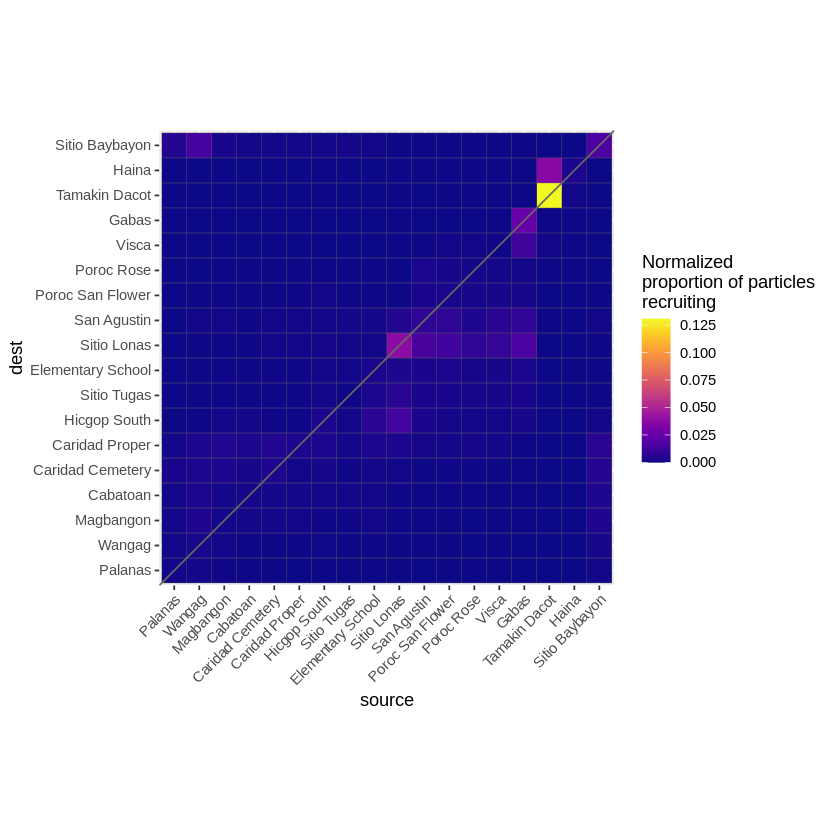

In [153]:
AllYearsNormConn$source <-factor(AllYearsNormConn$source, levels=c("Palanas", "Wangag",  "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School",  "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca",  "Gabas",  "Tamakin Dacot", "Haina", "Sitio Baybayon", "CAI", "Other"))
AllYearsNormConn$dest <-factor(AllYearsNormConn$dest, levels=c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon", "CAI", "Other"))

AllYearNorm <- ggplot(AllYearsNormConn[source != "Other" & dest != "Other" & source != "CAI" & dest != "CAI" ], aes(source, dest)) + 
    geom_tile(aes(fill = source_norm_rec), color = "grey40")+
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="plasma", name="Normalized \nproportion of particles \nrecruiting") +
    geom_abline(slope=1,color = "grey40")
AllYearNorm
#ggsave(filename="SimmConnMatAllYearsNormSurveyedSites.png", plot= AllYearNorm, path="~/oceanography/script_output/plots/" )
